In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scotia
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.spatial import distance_matrix
from scipy.stats import ranksums
from matplotlib.collections import LineCollection
from statsmodels.stats.multitest import multipletests
import warnings
warnings.filterwarnings("ignore")
import sys

In [7]:
#sample 121_3 healthy
#sample 115_17 injured
datap = '/your/workspace/'

In [12]:
#get DBSCAN cell clusters
for sample_id in ['121_3']:
    print(sample_id)
        
    celltype = []
    cell_idx = []
    meta_df_fov = pd.read_csv(datap+'7.slideseqv2/0.data/'+sample_id+'.medulla.summary.new.txt',sep = '\t',header = 0,index_col = None)
    meta_df_fov['index'] = range(meta_df_fov.shape[0])

    cell_type_l = list(set(meta_df_fov['annotation']))
    for ct in cell_type_l:
    #for ct in ['DCT','Macrophage']:
        ###cluster cells
        #print(ct)
        meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
        X = np.array(meta_df_sel[['x_pos','y_pos']])
        if X.shape[0] >= 10:
            print(ct)
            idx_l, fi_eps = scotia.dbscan_ff_cell(X, X_index_arr=np.array(meta_df_sel['index']),eps_l = list(range(1,600,5)))
            if len(idx_l)>0:
                celltype += [ct for x in idx_l]
                cell_idx += idx_l
    tmp_df = pd.DataFrame([celltype,cell_idx]).T
    np.save(datap+'7.slideseqv2/output/clustering/'+sample_id+'_dbscan.cell.clusters.new',tmp_df)
    

121_3
CD-IC
eps: 256
DCT
eps: 231
Other_Immune
eps: 76
Fibroblast
eps: 121
EC
eps: 21
MC
eps: 466
PCT
eps: 46
vSMC
eps: 241
GC
eps: 31
CD-PC
eps: 116
TAL
eps: 141
Podocyte
eps: 86
Macrophage
eps: 196


121_3
CD-IC


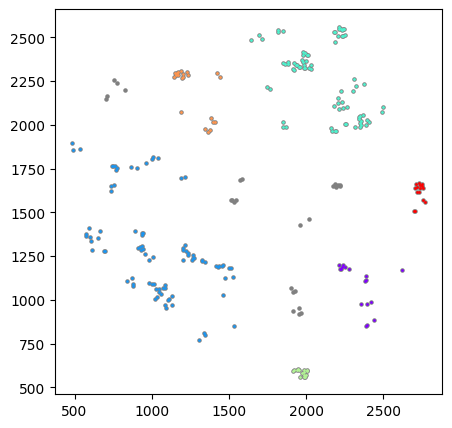

DCT


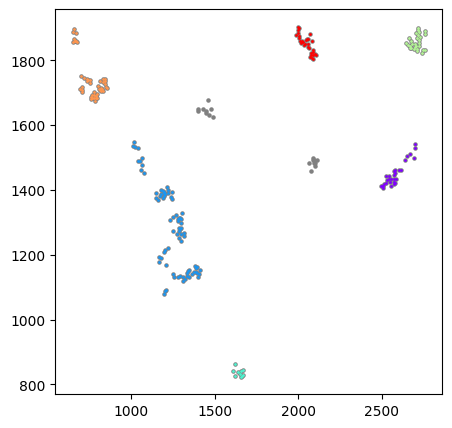

Other_Immune


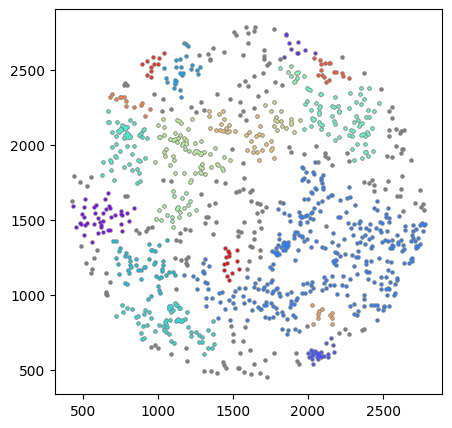

Fibroblast


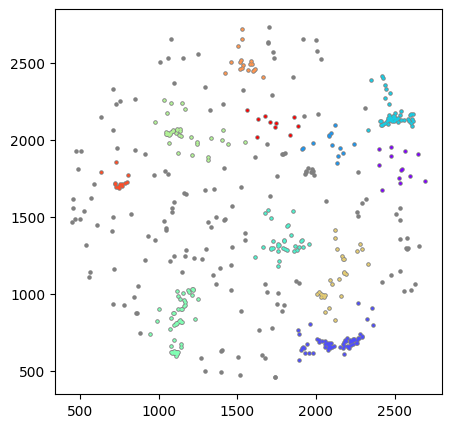

EC


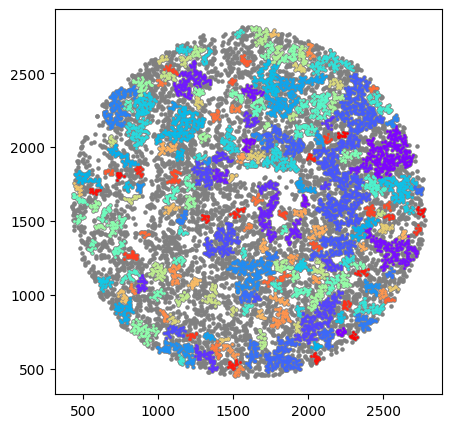

PCT


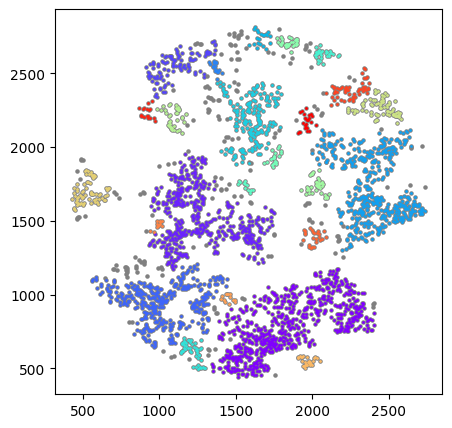

vSMC


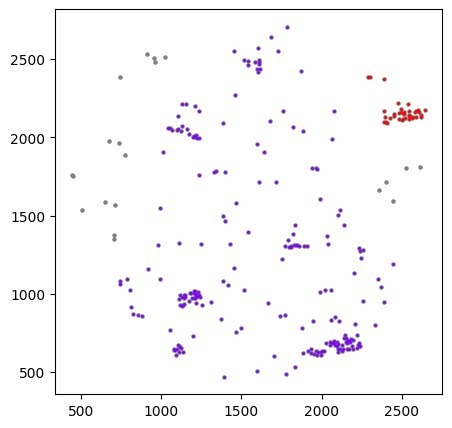

GC


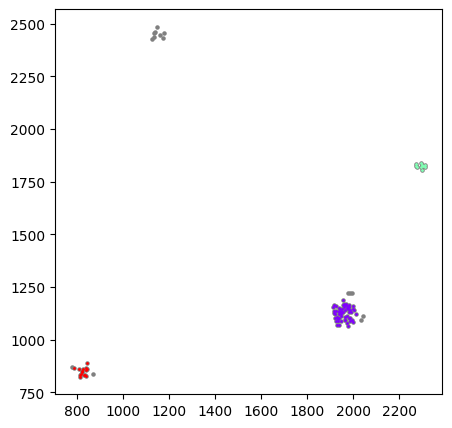

CD-PC


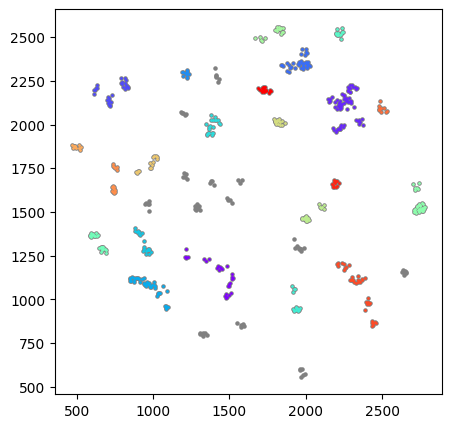

TAL


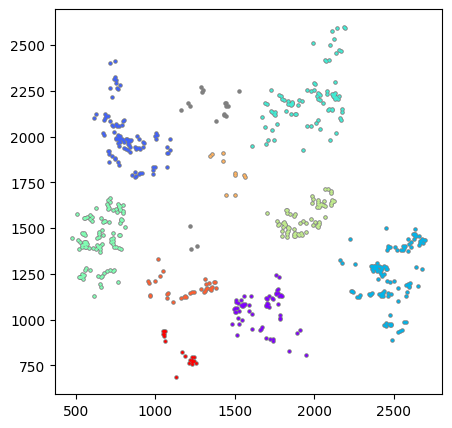

Podocyte


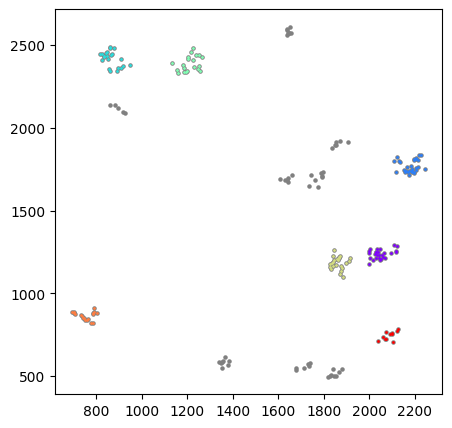

Macrophage


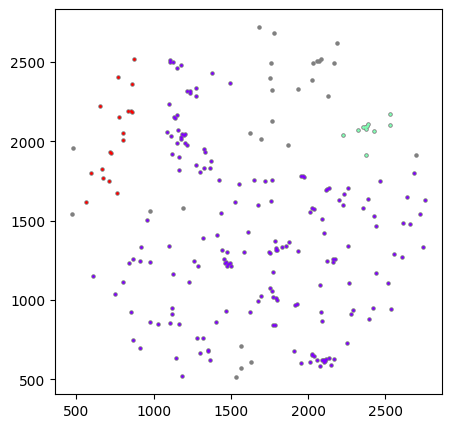

In [13]:
#visualization of DBSCAN clustering result
#legend: each dot is a cell, cells of the same color are from the same cluster, cells in the grey color are the noise identified by DBSCAN
for sample_id in ['121_3']:
    print(sample_id)
   
    meta_df_fov = pd.read_csv(datap+'7.slideseqv2/0.data/'+sample_id+'.medulla.summary.new.txt',sep = '\t',header = 0,index_col = None)

    cluster_df = pd.DataFrame(np.load(datap+'7.slideseqv2/output/clustering/'+sample_id+'_dbscan.cell.clusters.new.npy',allow_pickle=True)) #final
    
    cluster_df.columns = ['cell_type','cell_idx']


    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_type_l = list(set(cluster_df['cell_type']))
    for ct in cell_type_l:
    #for ct in ['EC']:
        print(ct)
        plt.figure(figsize=(5,5))
        #plot all ct cells
        meta_df_sel = meta_df_fov[meta_df_fov['annotation']==ct]
        X_sel = np.array(meta_df_sel[['x_pos','y_pos']])
        plt.scatter(X_sel[:,0],X_sel[:,1],c = 'grey',s = 5)

        #higlight clusters for ct cells
        tmp_ct = cluster_df[cluster_df['cell_type']==ct]
        colors = cm.rainbow(np.linspace(0, 1, tmp_ct.shape[0]))

        for n,line in enumerate(tmp_ct['cell_idx']):
            X = np.array(meta_df_fov.loc[line][['x_pos','y_pos']])
            plt.scatter(X[:,0],X[:,1],color =colors[n],s = 1)
        plt.show()

In [16]:
colors_dic = {
    'EC':'lightskyblue',
    'PCT':'orchid',
    'Other_Immune':'grey',
    'TAL':'gold',
    'vSMC':'purple',
    'Fibroblast':'teal',
    'Podocyte':'blueviolet',
    'MC':'cyan',
    'GC':'red',
    'MD':'lime',
    'CD-PC':'green',
    'CD-IC':'yellowgreen',
    'Macrophage':'deeppink',
    'DCT':'orange',
    
}
cells_l = ['EC','PCT','TAL','Other_Immune','vSMC','Fibroblast','Podocyte','MC','GC','MD','CD-PC','CD-IC','Macrophage','DCT']

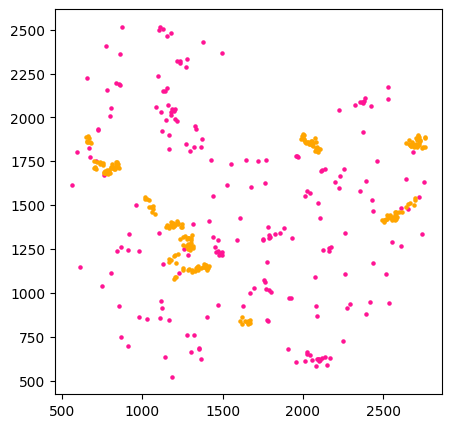

In [18]:
#visualization of cell types
for sample_id in ['121_3']:
   
    meta_df_fov = pd.read_csv(datap+'7.slideseqv2/0.data/'+sample_id+'.medulla.summary.new.txt',sep = '\t',header = 0,index_col = None)

    cluster_df = pd.DataFrame(np.load(datap+'7.slideseqv2/output/clustering/'+sample_id+'_dbscan.cell.clusters.new.npy',allow_pickle=True)) #final
    cluster_df.columns = ['cell_type','cell_idx']


    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_type_l = list(set(cluster_df['cell_type']))
    plt.figure(figsize=(5,5))
    #for ct in cells_l:
    #for ct in ['TAL']:
    for ct in ['Macrophage','DCT']:
        tmp_ct = cluster_df[cluster_df['cell_type']==ct]
        sel_ids = list(tmp_ct.explode('cell_idx')['cell_idx'])
        X = np.array(meta_df_fov.loc[sel_ids][['x_pos','y_pos']])
        plt.scatter(X[:,0],X[:,1],color = colors_dic[ct],s = 5,label=ct)
    plt.show()
   

In [19]:
#a
#ot
exp_df_all = pd.read_csv(datap+'7.slideseqv2/0.data/injured_normal_exp_matrix.txt',sep='\t',index_col=None)
exp_df_norm = exp_df_all.iloc[:,4:]
exp_df_norm = exp_df_norm[exp_df_norm>0]
df_quantile = exp_df_norm.quantile(q=0.99,axis = 0) 
df_quantile
known_lr_pairs = pd.read_csv(datap+'7.slideseqv2/0.data/LigRec_secreted_human_after_filtered.txt',sep=' ',header=None,index_col=None)
known_lr_pairs.columns = ['l_gene','r_gene']
for sample_id in ['131_3']:
   
    meta_df_fov = pd.read_csv(datap+'7.slideseqv2/0.data/'+sample_id+'.medulla.summary.new.txt',sep = '\t',header = 0,index_col = None)
    cluster_df = pd.DataFrame(np.load(datap+'7.slideseqv2/output/clustering/'+sample_id+'_dbscan.cell.clusters.new.npy',allow_pickle=True))
    cluster_df.columns = ['cell_type','cell_idx']

    #coordinates
    meta_df_fov.index = range(meta_df_fov.shape[0])
    cell_id_all = np.array(range(meta_df_fov.shape[0]))
    coord = np.array(meta_df_fov[['x_pos','y_pos']])
    S_all_arr = distance_matrix(coord,coord)

    #expression
    exp_df_fov = meta_df_fov.iloc[:,4:]
    exp_df_fov = exp_df_fov/df_quantile
    exp_df_fov[exp_df_fov>1]=1
    exp_df_fov.index = cell_id_all

    #select potentially communicating cell cluster pairs (spatially adjacent)
    S_all_arr_new = scotia.sel_pot_inter_cluster_pairs(S_all_arr,cluster_df,effect_range=10)

    #optimal transport between source and target cells
    ga_df_final = scotia.source_target_ot(S_all_arr_new, exp_df_fov, meta_df_fov, known_lr_pairs,dist_cutoff=10)
    if ga_df_final.shape[0]>0:
        ga_df_final.columns = ['source_cell_idx','receptor_cell_idx','likelihood','ligand_recptor','source_cell_type','target_cell_type']
        ga_df_final.to_csv(datap+'7.slideseqv2/output/ot/'+sample_id+".ot.new.15.csv",header = True, index = False, sep = "\t")

        #post-processing of ot results by calculating averaged likelihoods
        ga_df_final['cell_pairs'] = ga_df_final['source_cell_type']+"_"+ga_df_final['target_cell_type']
        final_summary = scotia.post_ot(ga_df_final,label=sample_id+"_fov_")
        final_summary.to_csv(datap+'7.slideseqv2/output/ot/summary/'+sample_id+".ot.new.15.csv",header = True, index = False, sep = "\t")



In [20]:
sample_id = '121_3'
final_summary = pd.read_csv(datap+'7.slideseqv2/output/ot/summary/'+sample_id+".ot.new.15.csv",header = 0, index_col = None, sep = "\t")
final_summary['lr_pairs'] = [x.split('|')[0] for x in final_summary['label']]
final_summary['cell_pairs'] = [x.split('|')[2] for x in final_summary['label']]
final_summary['ct1'] = [x.split('_')[0] for x in final_summary['cell_pairs']]
final_summary['ct2'] = [x.split('_')[1] for x in final_summary['cell_pairs']]
final_summary_sel = final_summary[final_summary['ct1']=='Macrophage']
df_normal = final_summary_sel.groupby(['ct2'])['ave_likelihood'].median().to_frame()
df_normal.columns = ['Normal']
df_normal

,Normal
ct2,
CD-IC,0.290442
CD-PC,0.333380
DCT,0.387960
EC,0.382080
Fibroblast,0.343834
Other,0.345875
PCT,0.293297
Podocyte,0.699949
TAL,0.270936


In [22]:
sample_id = '115_17'
final_summary = pd.read_csv(datap+'7.slideseqv2/output/ot/summary/'+sample_id+".ot.new.15.csv",header = 0, index_col = None, sep = "\t")
final_summary['lr_pairs'] = [x.split('|')[0] for x in final_summary['label']]
final_summary['cell_pairs'] = [x.split('|')[2] for x in final_summary['label']]
final_summary['ct1'] = [x.split('_')[0] for x in final_summary['cell_pairs']]
final_summary['ct2'] = [x.split('_')[1] for x in final_summary['cell_pairs']]
final_summary_sel = final_summary[final_summary['ct1']=='Macrophage']
df_injured = final_summary_sel.groupby(['ct2'])['ave_likelihood'].median().to_frame()
df_injured.columns = ['Injured']
df_injured

,Injured
ct2,
CD-IC,0.305284
CD-PC,0.285054
EC,0.323118
Fibroblast,0.335380
Other,0.332353
TAL,0.326146
vSMC,0.310747


In [23]:
df_compare = df_normal['Normal'].to_frame().join(df_injured['Injured'],how='outer')
df_compare[np.isnan(df_compare)==True]=0
df_compare['diff'] = df_compare['Normal'] - df_compare['Injured']
df_compare = df_compare.sort_values('diff')
df_compare

,Normal,Injured,diff
ct2,,,
TAL,0.270936,0.326146,-0.055210
vSMC,0.266212,0.310747,-0.044536
CD-IC,0.290442,0.305284,-0.014842
Fibroblast,0.343834,0.335380,0.008454
Other,0.345875,0.332353,0.013522
CD-PC,0.333380,0.285054,0.048327
EC,0.382080,0.323118,0.058962
PCT,0.293297,0.000000,0.293297
DCT,0.387960,0.000000,0.387960


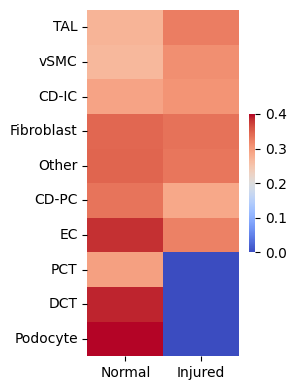

In [24]:
#plt.figure(figsize = (10,11))
plt.figure(figsize = (3,4))
sns.heatmap(df_compare[['Normal','Injured']],cmap='coolwarm',vmax=0.4,cbar_kws={'shrink': 0.4})
plt.ylabel("")
plt.tight_layout()
plt.savefig(datap+'7.slideseqv2/output/Figs/Macrophage_interactions.pdf')